# Intro
Voy a hacer un proyecto basico basado en la competicion de Kaggle [Give Me Some Credit](https://www.kaggle.com/competitions/GiveMeSomeCredit/data) donde lo que buscamos es predecir la probabilidad de que alguien muestre estres financiero en los proximos dos años.

# Imports

In [72]:
# --- Core libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint


# --- Preprocessing ---
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# --- Models ---
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# --- Metrics ---
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    average_precision_score,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

# Load
Vamos a cargar los archivos que tenemos para ver siquiera que pinta tienen. Los archivos que venian acompañados de la competicion son:
    - rejected: Tenemos informacion sobre los creditos que fueron rechazados
    - acepted: Informacion sobre los creditos que fueron aceptados


In [73]:
df_test = pd.read_csv("../data/raw/cs-test.csv")
df_train = pd.read_csv("../data/raw/cs-training.csv")
data_dictionary = pd.read_excel("../data/raw/Data Dictionary.xlsx",sheet_name=0,header=1)

# EDA

## Target separation
Vamos a quedarnos por un lado con el target que es el vector de si la gente entro en riesgo, que es SeriousDlqin2yrs

In [74]:
y_train = df_train["SeriousDlqin2yrs"]
y_train

0         1
1         0
2         0
3         0
4         0
         ..
149995    0
149996    0
149997    0
149998    0
149999    0
Name: SeriousDlqin2yrs, Length: 150000, dtype: int64

## Variable description

In [75]:
print(data_dictionary.to_markdown())

|    | Variable Name                        | Description                                                                                                                                              | Type       |
|---:|:-------------------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------|
|  0 | SeriousDlqin2yrs                     | Person experienced 90 days past due delinquency or worse                                                                                                 | Y/N        |
|  1 | RevolvingUtilizationOfUnsecuredLines | Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits | percentage |
|  2 | age                                  | Age of borrower in years                                                                          

## Some cleaning
Sacamos la columna que no sirve

In [76]:
df_train.drop(df_train[['Unnamed: 0']],axis=1,inplace=True)

## Describe

In [77]:
df_train.loc[:,df_train.columns != 'SeriousDlqin2yrs'].describe()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [78]:
df_train.dtypes

SeriousDlqin2yrs                          int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object

## Chequemos nulos

In [79]:
df_train.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

Veo que hay muchos nulos en el caso del 

## Exploracion del target

### Clase a predecir

Veamos que tan desbalanceado esta el problema

In [80]:
df_train.SeriousDlqin2yrs.value_counts()/len(df_train)*100

SeriousDlqin2yrs
0    93.316
1     6.684
Name: count, dtype: float64

Es un problema totalmente desbalanceado, donde tenemos solo un 6% de la clase positiva. Por lo tanto tendremos que tener cuidado tanto a la hora de entrenar como de predecir y entender

Recordemos de lo que vimos antes que tenemos una buena cantidad de nulos, como es la distribucion de las clases a predecir cuando el income es nullo?

In [81]:
df_train[df_train["MonthlyIncome"].isnull()].SeriousDlqin2yrs.value_counts()/len(df_train[df_train["MonthlyIncome"].isnull()])*100

SeriousDlqin2yrs
0    94.386331
1     5.613669
Name: count, dtype: float64

Y con respecto al total de los datos?

In [82]:
df_train[df_train["MonthlyIncome"].isnull()].SeriousDlqin2yrs.value_counts()/len(df_train)*100

SeriousDlqin2yrs
0    18.708000
1     1.112667
Name: count, dtype: float64

Y si sumamos income 0?

In [83]:
df_train[(df_train['MonthlyIncome']==0) | (df_train['MonthlyIncome'].isna())].SeriousDlqin2yrs.value_counts()/len(df_train)*100

SeriousDlqin2yrs
0    19.753333
1     1.156667
Name: count, dtype: float64

Aca tenemos que hacer un salto de fe importante con respecto al income. Y es que estamos hablando del contexto de riesgo crediticio y ademas una de las features que tenemos es _DebtIncome_, lo cual esta definido como el cociente entre la deuda y el income por lo que no deberia ser posible tener montos = 0, y en el caso de los monton nullos uno podria tratar de imputarlos de alguna manera, sin embargo como no tenemos el dato de la dueda que se usa para calcular el ratio no podemos inferir el income. Por lo que lo que vamos a hacer es dropear de nuestro entrenamiento este tipo de registros

In [84]:
df_train.drop(df_train[df_train['MonthlyIncome'].isna()==True].index,inplace=True)

In [85]:
df_train.drop(df_train[df_train['MonthlyIncome']==0].index,inplace=True)

In [86]:
df_train.SeriousDlqin2yrs.value_counts()

SeriousDlqin2yrs
0    110344
1      8291
Name: count, dtype: int64

In [87]:
df_train.SeriousDlqin2yrs.value_counts()/len(df_train)*100

SeriousDlqin2yrs
0    93.011337
1     6.988663
Name: count, dtype: float64

# Feature importance?

In [88]:
X = df_train.drop('SeriousDlqin2yrs',axis = 1)
y = df_train['SeriousDlqin2yrs']

In [89]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X, y, random_state=0)
pd.Series(mi, index=X.columns).sort_values(ascending=False)

RevolvingUtilizationOfUnsecuredLines    0.035077
NumberOfTimes90DaysLate                 0.030259
NumberOfTime30-59DaysPastDueNotWorse    0.027442
NumberOfTime60-89DaysPastDueNotWorse    0.019255
NumberRealEstateLoansOrLines            0.006957
age                                     0.006235
NumberOfOpenCreditLinesAndLoans         0.004107
DebtRatio                               0.003962
MonthlyIncome                           0.003398
NumberOfDependents                      0.002316
dtype: float64

<Axes: >

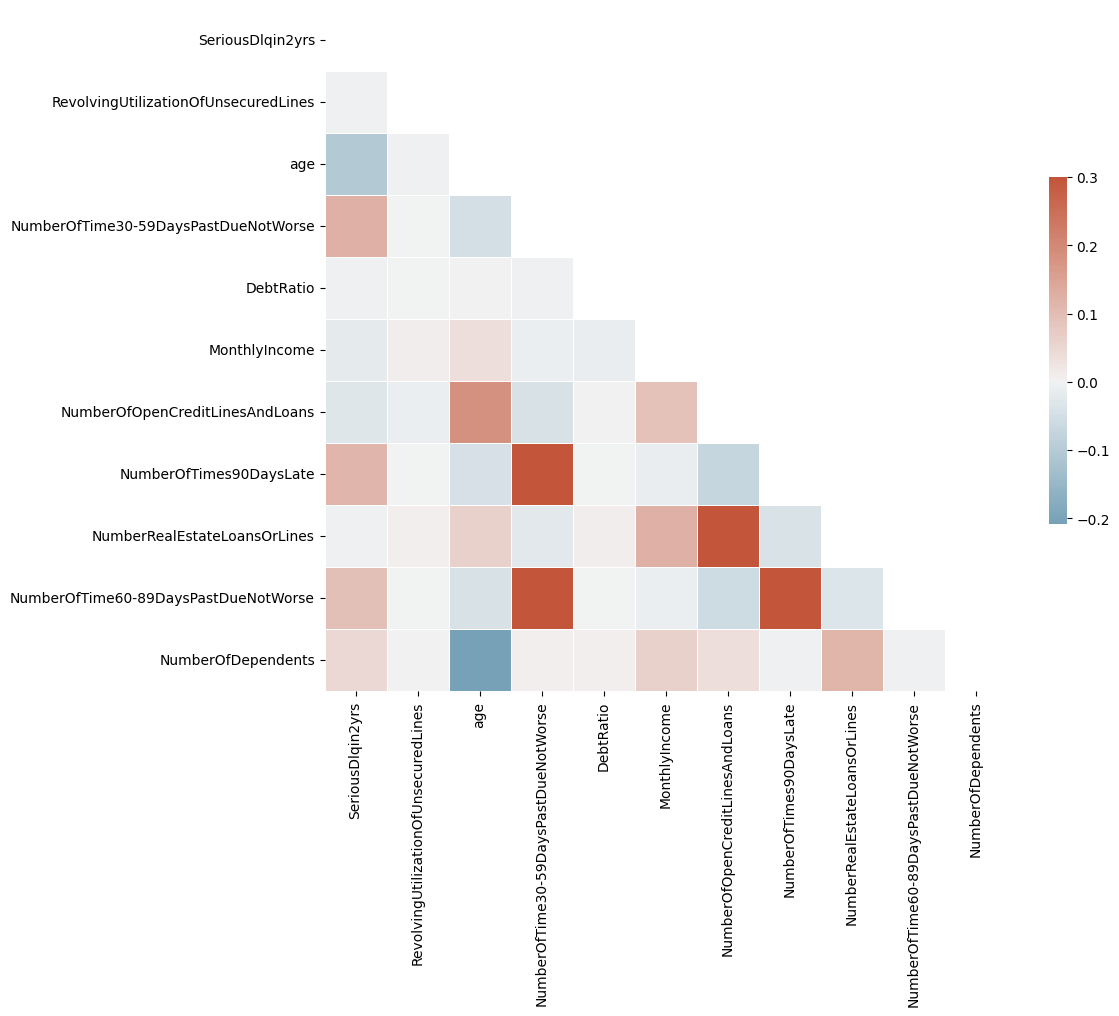

In [90]:
corr = df_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Outliers?

## Clasical IQR outliers detection
Works well for univariable outliers indentification, but what im going to do? Im just going to iteratly going to purge point from each feature? The problem with this aproach is that doing this im modifiying the othre features disribution so what was consireder an outliers it might not be in the future.

In [91]:
def get_iqr_info(df: pd.DataFrame, column: str):
    """
    Calculate and print the IQR, Q1, and Q3 for a given column in a DataFrame.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    column : str
        Column name to analyze.
    
    Returns
    -------
    dict
        A dictionary containing Q1, Q3, IQR, lower bound, and upper bound for outlier detection.
    """
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    print(f"Feature: {column}")
    print(f"Q1 (25th percentile): {q1:.4f}")
    print(f"Q3 (75th percentile): {q3:.4f}")
    print(f"IQR: {iqr:.4f}")
    print(f"Lower bound (outlier threshold): {lower_bound:.4f}")
    print(f"Upper bound (outlier threshold): {upper_bound:.4f}")
    print(f"Potential outliers: {( (df[column] < lower_bound) | (df[column] > upper_bound) ).sum()}")
    
    return {
        "Q1": q1,
        "Q3": q3,
        "IQR": iqr,
        "Lower Bound": lower_bound,
        "Upper Bound": upper_bound
    }


In [92]:
df_columns = df_train.columns

In [93]:
for column in df_train.columns:
    get_iqr_info(df_train,column)
    print("\n")

Feature: SeriousDlqin2yrs
Q1 (25th percentile): 0.0000
Q3 (75th percentile): 0.0000
IQR: 0.0000
Lower bound (outlier threshold): 0.0000
Upper bound (outlier threshold): 0.0000
Potential outliers: 8291


Feature: RevolvingUtilizationOfUnsecuredLines
Q1 (25th percentile): 0.0354
Q3 (75th percentile): 0.5802
IQR: 0.5448
Lower bound (outlier threshold): -0.7818
Upper bound (outlier threshold): 1.3973
Potential outliers: 538


Feature: age
Q1 (25th percentile): 41.0000
Q3 (75th percentile): 61.0000
IQR: 20.0000
Lower bound (outlier threshold): 11.0000
Upper bound (outlier threshold): 91.0000
Potential outliers: 170


Feature: NumberOfTime30-59DaysPastDueNotWorse
Q1 (25th percentile): 0.0000
Q3 (75th percentile): 0.0000
IQR: 0.0000
Lower bound (outlier threshold): 0.0000
Upper bound (outlier threshold): 0.0000
Potential outliers: 20103


Feature: DebtRatio
Q1 (25th percentile): 0.1415
Q3 (75th percentile): 0.4733
IQR: 0.3318
Lower bound (outlier threshold): -0.3562
Upper bound (outlier thres

## Isolation forest
Machine learning based anomaly detection, works good when we have mixed data types (categorical, continuos,discrete,ordinal etc)

In [94]:
from sklearn.ensemble import IsolationForest

def detect_outliers_iforest(df, cols, contamination=0.05, random_state=42):
    iso = IsolationForest(contamination=contamination, random_state=random_state)
    preds = iso.fit_predict(df[cols])
    return pd.DataFrame({
        "Anomaly_Score": iso.decision_function(df[cols]),
        "Outlier": preds == -1
    }, index=df.index)

## Mahalanobis Distance
The Mahalanobis distance is the distance of the test point from the center of mass divided by the width of the ellipsoid in the direction of the test point. This looks more promising as a clasical method to detect outliers

In [95]:
import numpy as np
import pandas as pd
from scipy.stats import chi2

def multivariate_outliers_mahalanobis(df, cols, alpha=0.001):
    X = df[cols].to_numpy()                     # use numpy array
    X_centered = X - X.mean(axis=0)
    cov = np.cov(X_centered, rowvar=False)
    inv_cov = np.linalg.inv(cov)
    
    # Mahalanobis distance
    md = np.sqrt(np.sum((X_centered @ inv_cov) * X_centered, axis=1))
    
    # Chi-square threshold
    threshold = np.sqrt(chi2.ppf((1 - alpha), df=len(cols)))
    outliers = md > threshold
    
    return pd.DataFrame({
        "Mahalanobis_Distance": md,
        "Outlier": outliers
    }, index=df.index)


## Consensus
We treat outliers has the consensus on both megalanobis and isolation forest

# Modeling

I already have vary outliers methods, but what happens if i use the data without removing anything? To keep it simple im going to test thw two most used methods to model $PD$:
- Logistic regresion
- Xgboost

### functions and report inicialization

In [96]:
def get_train_test(X,y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    return X_train, X_test, y_train, y_test

In [97]:
def get_pos_weight(y_train):
    # Calculate class imbalance ratio
    neg, pos = np.bincount(y_train)
    scale_pos_weight = neg / pos
    print(f"Class ratio: {neg}:{pos}, scale_pos_weight = {scale_pos_weight:.2f}")
    
    return scale_pos_weight

In [98]:
def get_models(sufix,y_train):
    models = {
        f"logistic_regression_{sufix}": {
            "estimator": Pipeline([
                ('scaler', StandardScaler()),
                ('clf', LogisticRegression(max_iter=5000, random_state=42))
            ]),
            "param_distributions": {
                'clf__C': uniform(0.001, 10),           # wide range of regularization
                'clf__penalty': ['l2'],
                'clf__solver': ['lbfgs', 'saga'],
                'clf__class_weight': [None, 'balanced']
            }
        },

        f"xgboost_{sufix}": {
            "estimator": XGBClassifier(
                use_label_encoder=False,
                eval_metric='logloss',
                random_state=42,
                scale_pos_weight=get_pos_weight(y_train)
            ),
            "param_distributions": {
                'n_estimators': randint(100, 600),
                'max_depth': randint(3, 10),
                'learning_rate': uniform(0.01, 0.3),
                'subsample': uniform(0.6, 0.4),
                'colsample_bytree': uniform(0.6, 0.4),
                'min_child_weight': randint(1, 10),
                'gamma': uniform(0, 5),
                'reg_lambda': uniform(0, 5),
                'reg_alpha': uniform(0, 5)
            }
        }
    }

    return models

In [99]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score,
    roc_auc_score
)
import numpy as np
import pandas as pd

def plot_model_diagnostics(y_true, y_prob, model_name=None):
    """
    Generate ROC, PR, Lift, Cumulative Gain, and KS curves for a classification model.
    
    Parameters
    ----------
    y_true : array-like
        True binary labels.
    y_prob : array-like
        Predicted probabilities for the positive class.
    model_name : str, optional
        Name of the model for titles.
    """
    model_name = model_name or "Model"
    
    # ===== ROC CURVE =====
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    # ===== PRECISION-RECALL CURVE =====
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    
    # ===== KS CURVE =====
    # (useful in credit risk / PD modeling)
    ks_statistic = max(tpr - fpr)
    
    # ===== LIFT & CUMULATIVE GAIN =====
    df = pd.DataFrame({'y_true': y_true, 'y_prob': y_prob}).sort_values('y_prob', ascending=False)
    df['cum_positive'] = df['y_true'].cumsum()
    total_positives = df['y_true'].sum()
    df['gain'] = df['cum_positive'] / total_positives
    df['perc_samples'] = np.arange(1, len(df) + 1) / len(df)
    df['lift'] = df['gain'] / df['perc_samples']
    
    # ===== PLOT ALL =====
    plt.figure(figsize=(14, 10))
    
    # ROC
    plt.subplot(2, 2, 1)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{model_name} - ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')

    # PR Curve
    plt.subplot(2, 2, 2)
    plt.plot(recall, precision, label=f'AP = {pr_auc:.3f}')
    plt.title(f'{model_name} - Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left')

    # Cumulative Gain
    plt.subplot(2, 2, 3)
    plt.plot(df['perc_samples'], df['gain'], label='Cumulative Gain')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{model_name} - Cumulative Gain')
    plt.xlabel('% of Samples')
    plt.ylabel('% of Positives Captured')
    plt.legend(loc='lower right')

    # Lift Curve
    plt.subplot(2, 2, 4)
    plt.plot(df['perc_samples'], df['lift'], label='Lift')
    plt.axhline(y=1, color='k', linestyle='--')
    plt.title(f'{model_name} - Lift Curve')
    plt.xlabel('% of Samples')
    plt.ylabel('Lift')
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    print(f"🔹 {model_name} Metrics Summary")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC (Average Precision): {pr_auc:.4f}")
    print(f"KS Statistic: {ks_statistic:.4f}")

    return {
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'ks': ks_statistic
    }


In [100]:
def generate_train_test_report(name,config,X_train,X_test,y_train,y_test,cv):
    global results
    print(f"\n>>> Training {name} ...")

    search = RandomizedSearchCV(
        estimator=config['estimator'],
        param_distributions=config['param_distributions'],
        scoring = 'roc_auc',
        n_iter=10,              
        cv=cv,
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    search.fit(X_train, y_train)


    # Evaluate best model
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    metrics = {
        'model': name,
        'best_params': search.best_params_,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob),
        'pr_auc': average_precision_score(y_test,y_prob)
    }

    print(f"Classification report for {name}:\n", classification_report(y_test, y_pred))
    plot_model_diagnostics(y_test, y_prob, model_name=name)
    
    results.append(metrics)
    return best_model

In [101]:
results = []

### Full dataset (only nulls of Monthly income out)

In [102]:
X_train, X_test, y_train, y_test = get_train_test(X,y)

In [103]:
sufix = 'full_dataset'
models = get_models(sufix,y_train)

Class ratio: 88275:6633, scale_pos_weight = 13.31



>>> Training logistic_regression_full_dataset ...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Classification report for logistic_regression_full_dataset:
               precision    recall  f1-score   support

           0       0.97      0.83      0.90     22069
           1       0.22      0.61      0.32      1658

    accuracy                           0.82     23727
   macro avg       0.59      0.72      0.61     23727
weighted avg       0.91      0.82      0.85     23727



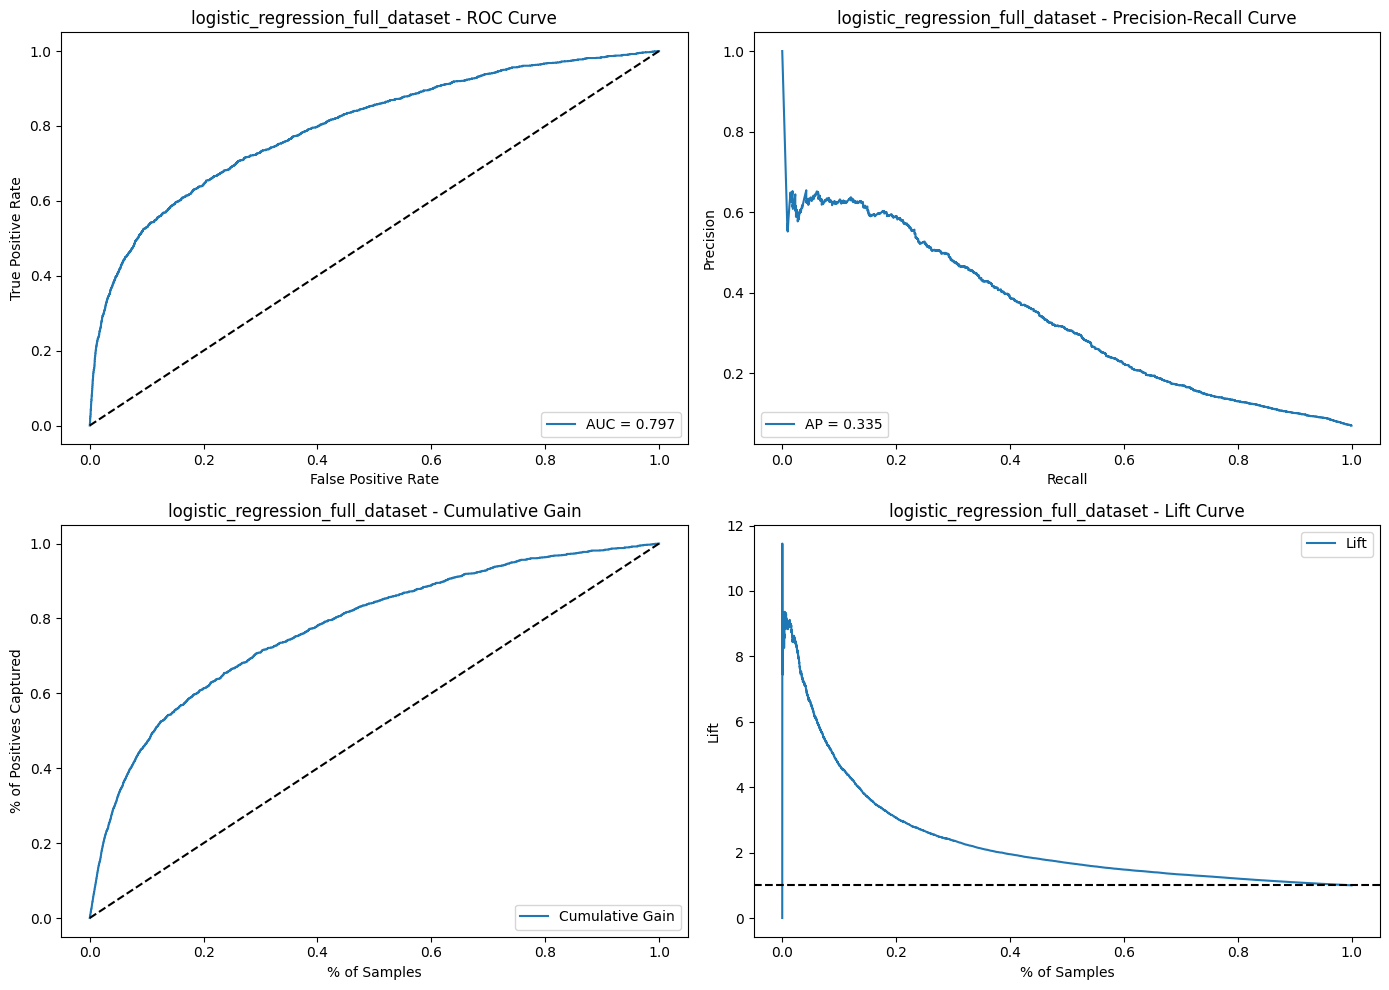

🔹 logistic_regression_full_dataset Metrics Summary
ROC-AUC: 0.7972
PR-AUC (Average Precision): 0.3352
KS Statistic: 0.4498

>>> Training xgboost_full_dataset ...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\ivanl\OneDrive\Desktop\Python\Credit Risk Prediction\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:59:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification report for xgboost_full_dataset:
               precision    recall  f1-score   support

           0       0.98      0.81      0.89     22069
           1       0.23      0.74      0.35      1658

    accuracy                           0.80     23727
   macro avg       0.60      0.77      0.62     23727
weighted avg       0.92      0.80      0.85     23727



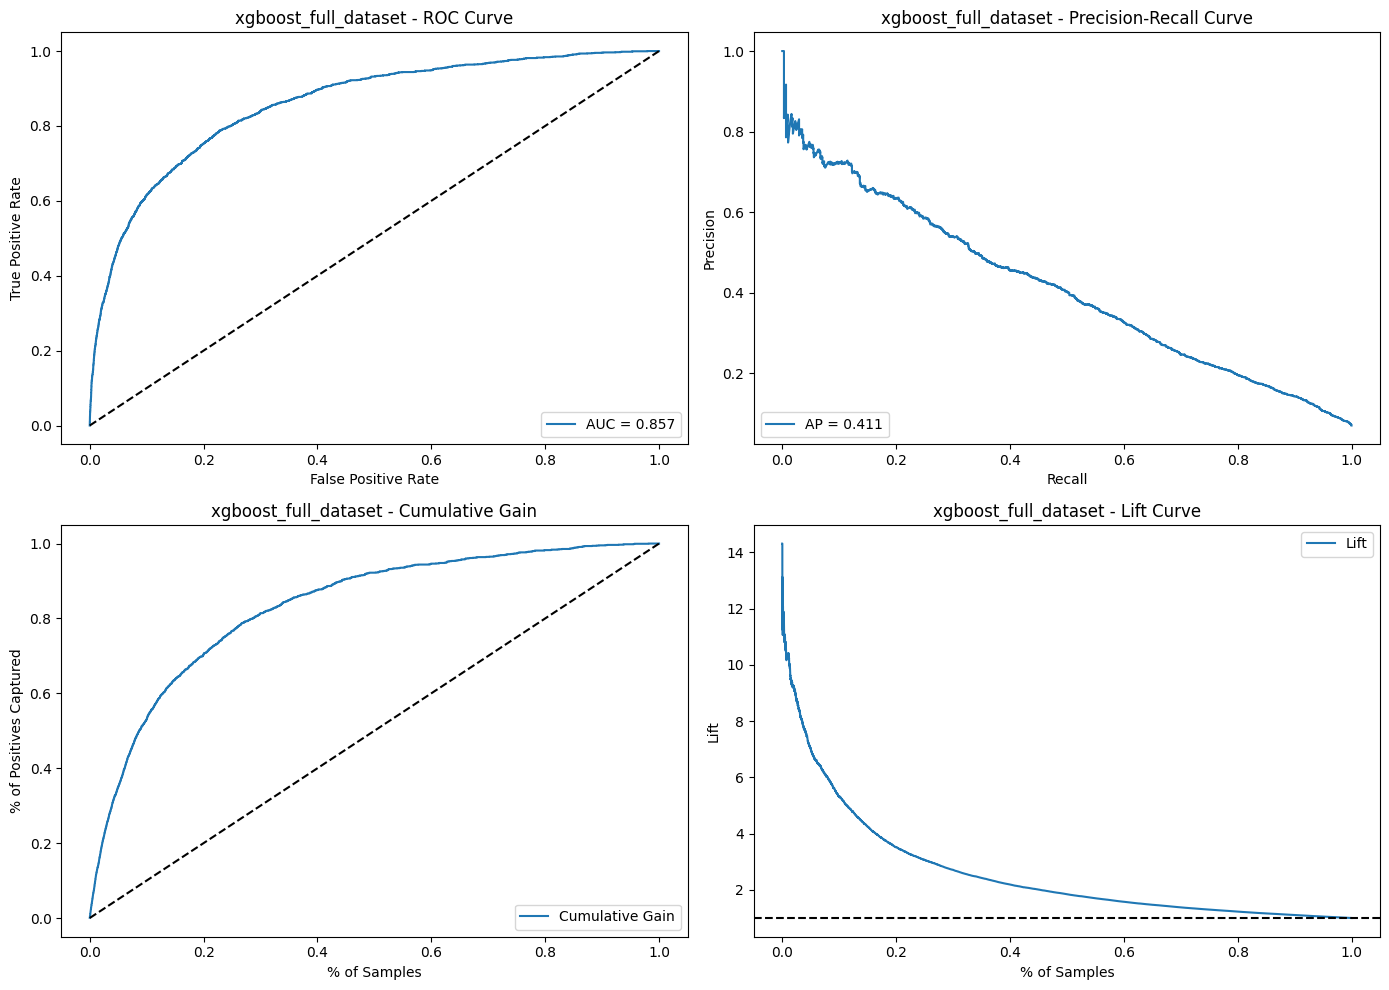

🔹 xgboost_full_dataset Metrics Summary
ROC-AUC: 0.8574
PR-AUC (Average Precision): 0.4107
KS Statistic: 0.5598


In [104]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, config in models.items():
    generate_train_test_report(name,config,X_train, X_test, y_train, y_test,cv)    



In [105]:
scoreboard = pd.DataFrame(results).sort_values(by='roc_auc', ascending=False)
print("\n=== Model Comparison ===")
scoreboard


=== Model Comparison ===


,model,best_params,accuracy,precision,recall,f1,roc_auc,pr_auc
1,xgboost_full_dataset,"{'colsample_bytree': 0.7085396127095583, 'gamm...",0.804822,0.226092,0.740048,0.346366,0.857371,0.410695
0,logistic_regression_full_dataset,"{'clf__C': 6.012150117432088, 'clf__class_weig...",0.818224,0.216286,0.610374,0.319394,0.797192,0.335196


## Deleting outliers based on isolation forest

In [106]:
df_out_iforest = detect_outliers_iforest(X, X.columns, contamination=0.05, random_state=42)
df_out_iforest.Outlier.value_counts()

Outlier
False    112703
True       5932
Name: count, dtype: int64

In [107]:
mask_inliers = df_out_iforest["Outlier"] == False

# Step 3: filter your X and y
X_clean = X[mask_inliers].reset_index(drop=True)
y_clean = y[mask_inliers].reset_index(drop=True)

Como quedo la distribucion?

In [108]:
y_clean.value_counts()/len(y_clean)

SeriousDlqin2yrs
0    0.945654
1    0.054346
Name: count, dtype: float64

In [109]:
X_train, X_test, y_train, y_test = get_train_test(X_clean,y_clean)

In [110]:
sufix = 'iforest'
models = get_models(sufix,y_train)

Class ratio: 85262:4900, scale_pos_weight = 17.40



>>> Training logistic_regression_iforest ...
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Classification report for logistic_regression_iforest:
               precision    recall  f1-score   support

           0       0.97      0.82      0.89     21316
           1       0.16      0.59      0.25      1225

    accuracy                           0.80     22541
   macro avg       0.56      0.70      0.57     22541
weighted avg       0.93      0.80      0.85     22541



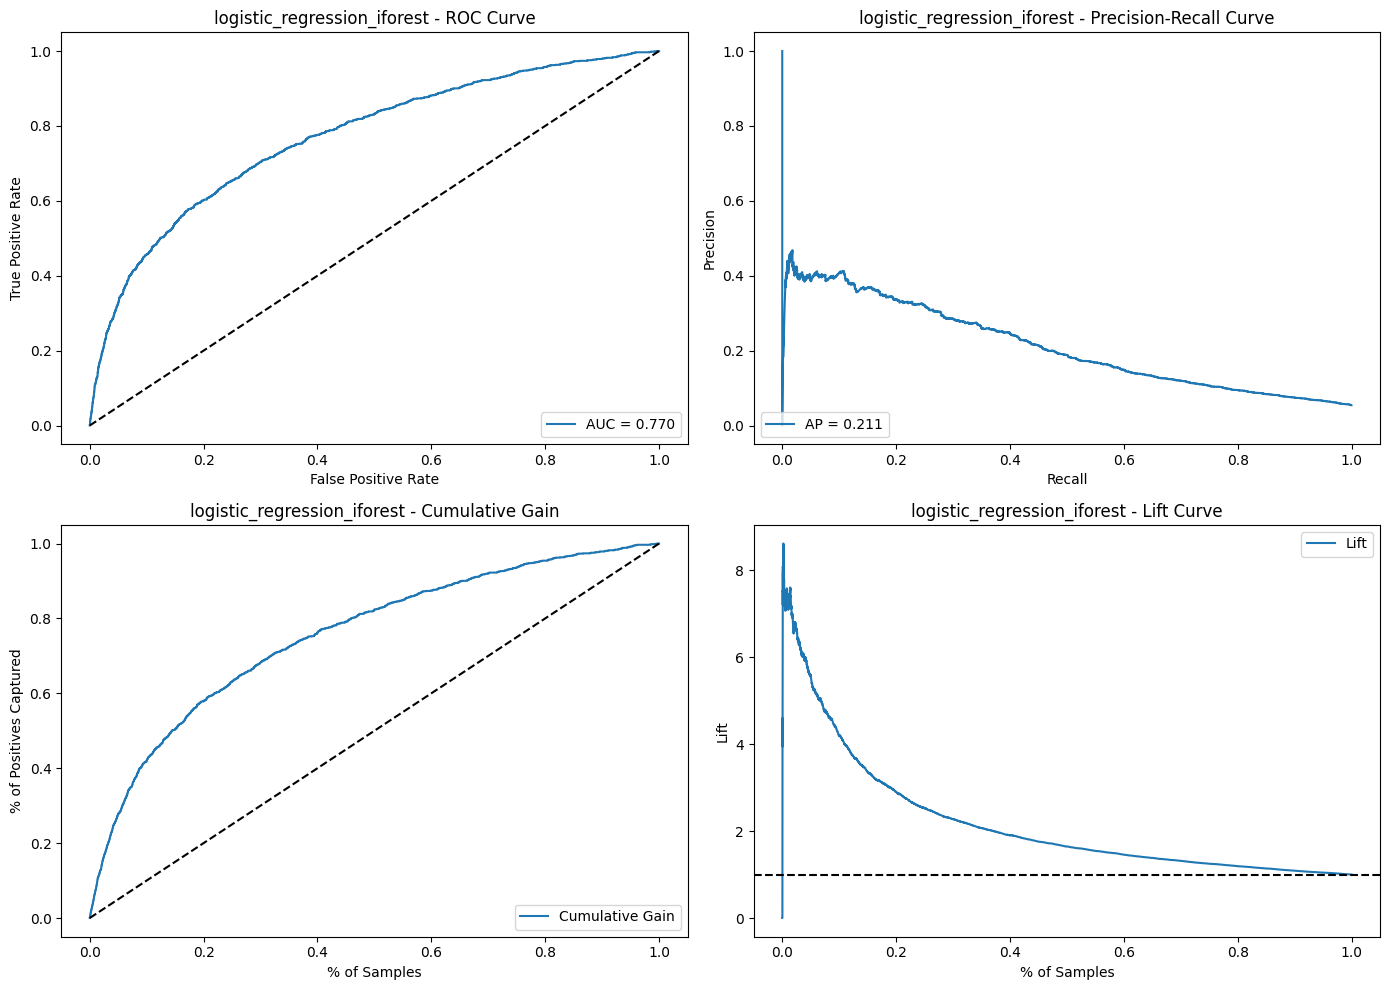

🔹 logistic_regression_iforest Metrics Summary
ROC-AUC: 0.7700
PR-AUC (Average Precision): 0.2113
KS Statistic: 0.4072

>>> Training xgboost_iforest ...
Fitting 4 folds for each of 10 candidates, totalling 40 fits


c:\Users\ivanl\OneDrive\Desktop\Python\Credit Risk Prediction\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [09:00:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification report for xgboost_iforest:
               precision    recall  f1-score   support

           0       0.98      0.73      0.84     21316
           1       0.14      0.75      0.24      1225

    accuracy                           0.73     22541
   macro avg       0.56      0.74      0.54     22541
weighted avg       0.94      0.73      0.81     22541



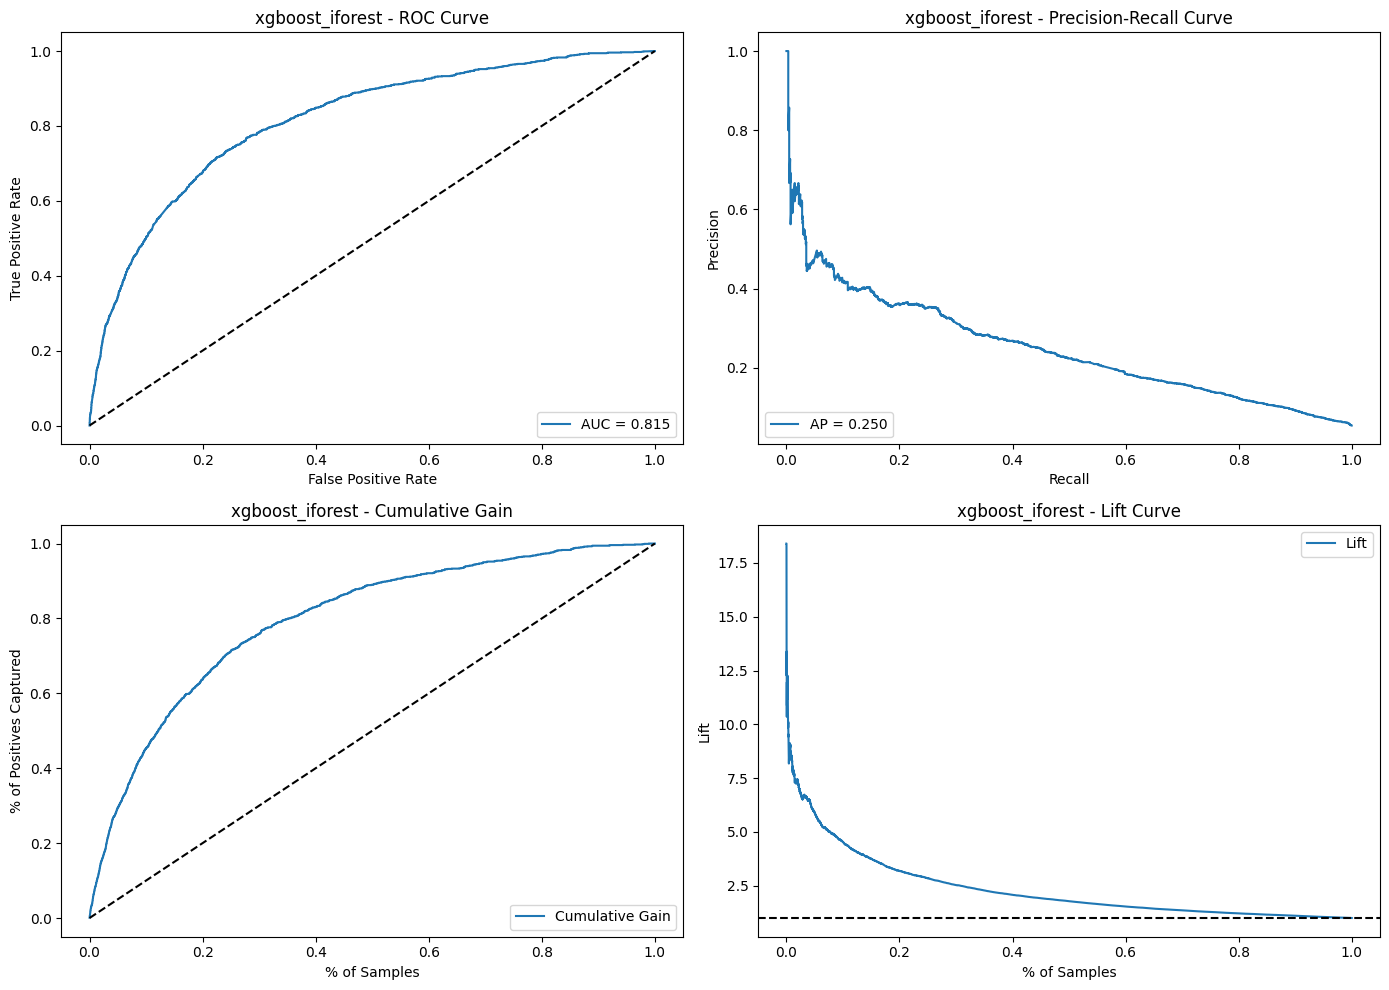

🔹 xgboost_iforest Metrics Summary
ROC-AUC: 0.8148
PR-AUC (Average Precision): 0.2499
KS Statistic: 0.4918


In [111]:
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
for name, config in models.items():
    generate_train_test_report(name,config,X_train, X_test, y_train, y_test,cv)    



In [112]:
scoreboard = pd.DataFrame(results).sort_values(by='pr_auc', ascending=False)
print("\n=== Model Comparison ===")
scoreboard


=== Model Comparison ===


,model,best_params,accuracy,precision,recall,f1,roc_auc,pr_auc
1,xgboost_full_dataset,"{'colsample_bytree': 0.7085396127095583, 'gamm...",0.804822,0.226092,0.740048,0.346366,0.857371,0.410695
0,logistic_regression_full_dataset,"{'clf__C': 6.012150117432088, 'clf__class_weig...",0.818224,0.216286,0.610374,0.319394,0.797192,0.335196
3,xgboost_iforest,"{'colsample_bytree': 0.908897907718663, 'gamma...",0.734218,0.139486,0.752653,0.235354,0.814755,0.249871
2,logistic_regression_iforest,"{'clf__C': 0.20684494295802447, 'clf__class_we...",0.803824,0.155273,0.587755,0.245650,0.769992,0.211340


## Deleting outliers based no mahalonobis

In [113]:
df_out_mahal = multivariate_outliers_mahalanobis(X, X.columns, alpha=0.001)
df_out_mahal.Outlier.value_counts()

Outlier
False    115550
True       3085
Name: count, dtype: int64

In [114]:
mask_inliers = df_out_mahal["Outlier"] == False

# Step 3: filter your X and y
X_clean = X[mask_inliers].reset_index(drop=True)
y_clean = y[mask_inliers].reset_index(drop=True)

Como quedo la distribucion?

In [115]:
y_clean.value_counts()/len(y_clean)

SeriousDlqin2yrs
0    0.9382
1    0.0618
Name: count, dtype: float64

In [116]:
X_train, X_test, y_train, y_test = get_train_test(X_clean,y_clean)

In [117]:
sufix = 'mahal'
models = get_models(sufix,y_train)

Class ratio: 86727:5713, scale_pos_weight = 15.18



>>> Training logistic_regression_mahal ...
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Classification report for logistic_regression_mahal:
               precision    recall  f1-score   support

           0       0.97      0.85      0.91     21682
           1       0.21      0.60      0.31      1428

    accuracy                           0.83     23110
   macro avg       0.59      0.73      0.61     23110
weighted avg       0.92      0.83      0.87     23110



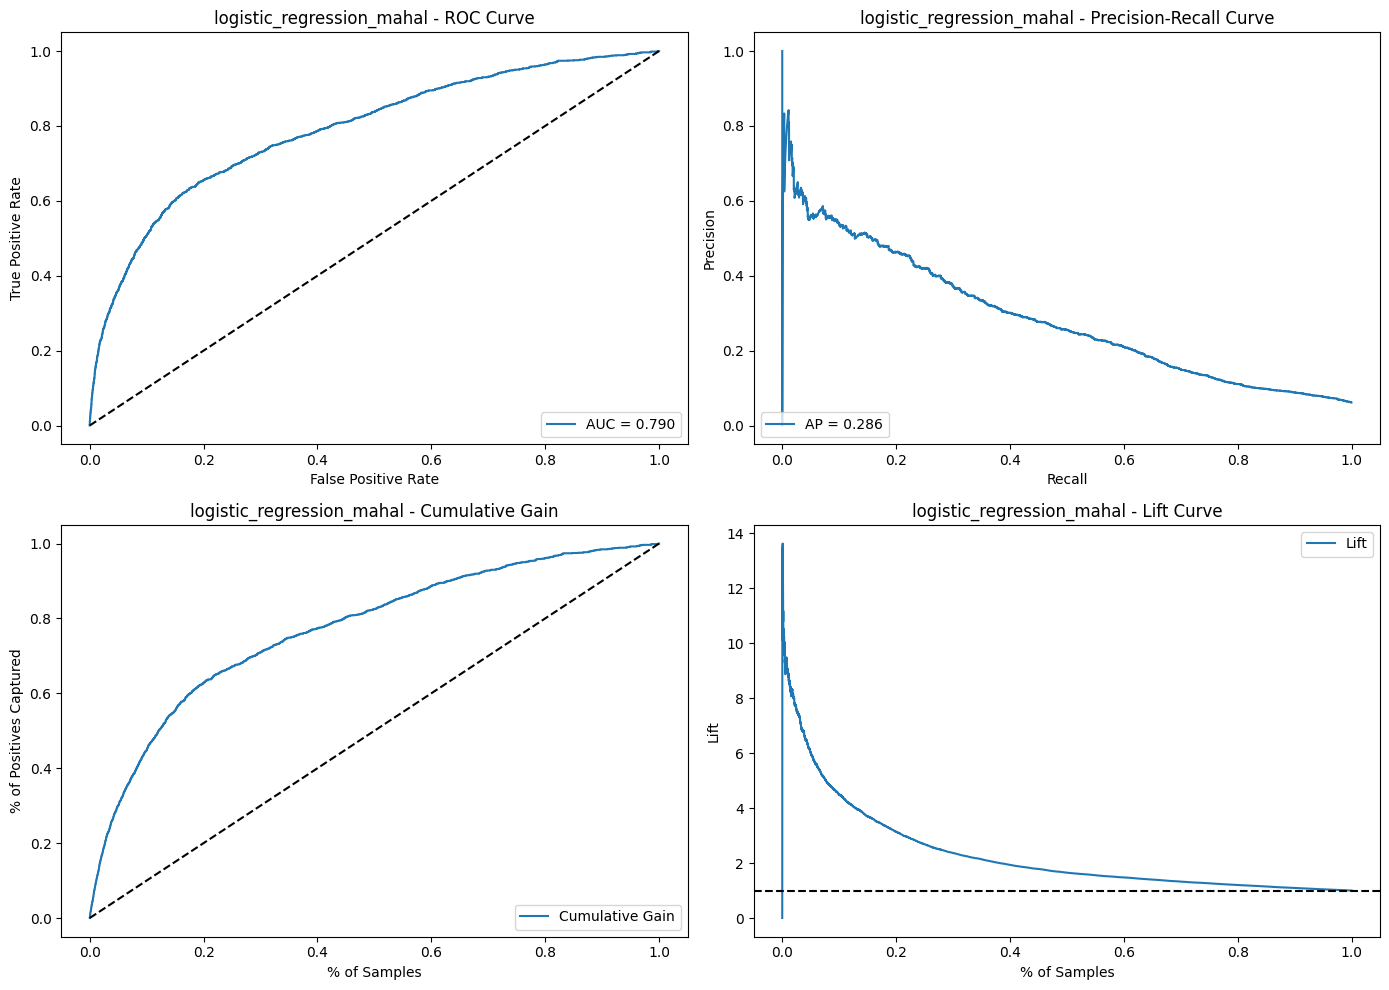

🔹 logistic_regression_mahal Metrics Summary
ROC-AUC: 0.7898
PR-AUC (Average Precision): 0.2860
KS Statistic: 0.4585

>>> Training xgboost_mahal ...
Fitting 4 folds for each of 10 candidates, totalling 40 fits


c:\Users\ivanl\OneDrive\Desktop\Python\Credit Risk Prediction\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [09:01:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification report for xgboost_mahal:
               precision    recall  f1-score   support

           0       0.98      0.76      0.86     21682
           1       0.17      0.77      0.28      1428

    accuracy                           0.76     23110
   macro avg       0.58      0.76      0.57     23110
weighted avg       0.93      0.76      0.82     23110



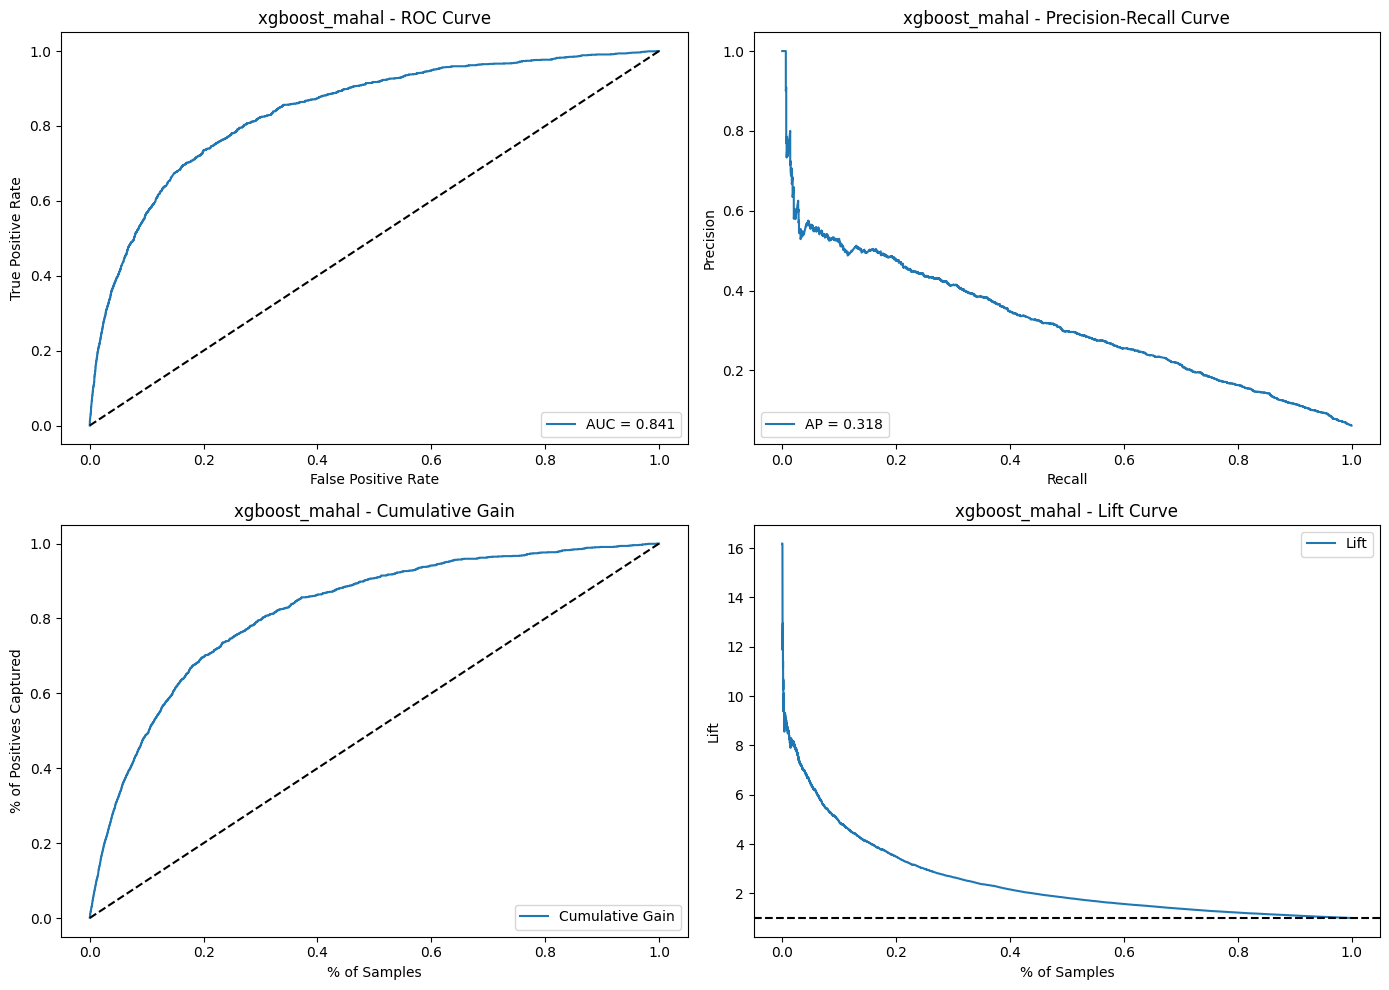

🔹 xgboost_mahal Metrics Summary
ROC-AUC: 0.8408
PR-AUC (Average Precision): 0.3182
KS Statistic: 0.5354


In [118]:
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
for name, config in models.items():
    generate_train_test_report(name,config,X_train, X_test, y_train, y_test,cv)    



In [119]:
scoreboard = pd.DataFrame(results).sort_values(by='pr_auc', ascending=False)
print("\n=== Model Comparison ===")
scoreboard


=== Model Comparison ===


,model,best_params,accuracy,precision,recall,f1,roc_auc,pr_auc
1,xgboost_full_dataset,"{'colsample_bytree': 0.7085396127095583, 'gamm...",0.804822,0.226092,0.740048,0.346366,0.857371,0.410695
0,logistic_regression_full_dataset,"{'clf__C': 6.012150117432088, 'clf__class_weig...",0.818224,0.216286,0.610374,0.319394,0.797192,0.335196
5,xgboost_mahal,"{'colsample_bytree': 0.908897907718663, 'gamma...",0.759498,0.173673,0.769608,0.283394,0.840846,0.318234
4,logistic_regression_mahal,"{'clf__C': 0.5818361216819946, 'clf__class_wei...",0.834444,0.208698,0.601541,0.309885,0.789826,0.286023
3,xgboost_iforest,"{'colsample_bytree': 0.908897907718663, 'gamma...",0.734218,0.139486,0.752653,0.235354,0.814755,0.249871
2,logistic_regression_iforest,"{'clf__C': 0.20684494295802447, 'clf__class_we...",0.803824,0.155273,0.587755,0.245650,0.769992,0.211340


## Deletin outliers based on consensus

In [120]:
# 3. Merge and analyze
df_out_iforest['Outlier_iso'] = df_out_iforest['Outlier']
df_outliers = X.join([df_out_mahal['Outlier'], df_out_iforest['Outlier_iso']])
df_outliers['Consensus_Outlier'] = df_outliers[['Outlier', 'Outlier_iso']].sum(axis=1) > 1
df_outliers['Consensus_Outlier'].value_counts()

Consensus_Outlier
False    116261
True       2374
Name: count, dtype: int64

In [121]:
mask_inliers = df_outliers["Consensus_Outlier"] == False

# Step 3: filter your X and y
X_clean = X[mask_inliers].reset_index(drop=True)
y_clean = y[mask_inliers].reset_index(drop=True)

Como quedo la distribucion?

In [122]:
y_clean.value_counts()/len(y_clean)

SeriousDlqin2yrs
0    0.937193
1    0.062807
Name: count, dtype: float64

In [123]:
X_train, X_test, y_train, y_test = get_train_test(X_clean,y_clean)

In [124]:
sufix = 'consensus'
models = get_models(sufix,y_train)

Class ratio: 87166:5842, scale_pos_weight = 14.92



>>> Training logistic_regression_consensus ...
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Classification report for logistic_regression_consensus:
               precision    recall  f1-score   support

           0       0.97      0.86      0.91     21793
           1       0.22      0.59      0.32      1460

    accuracy                           0.84     23253
   macro avg       0.60      0.73      0.62     23253
weighted avg       0.92      0.84      0.88     23253



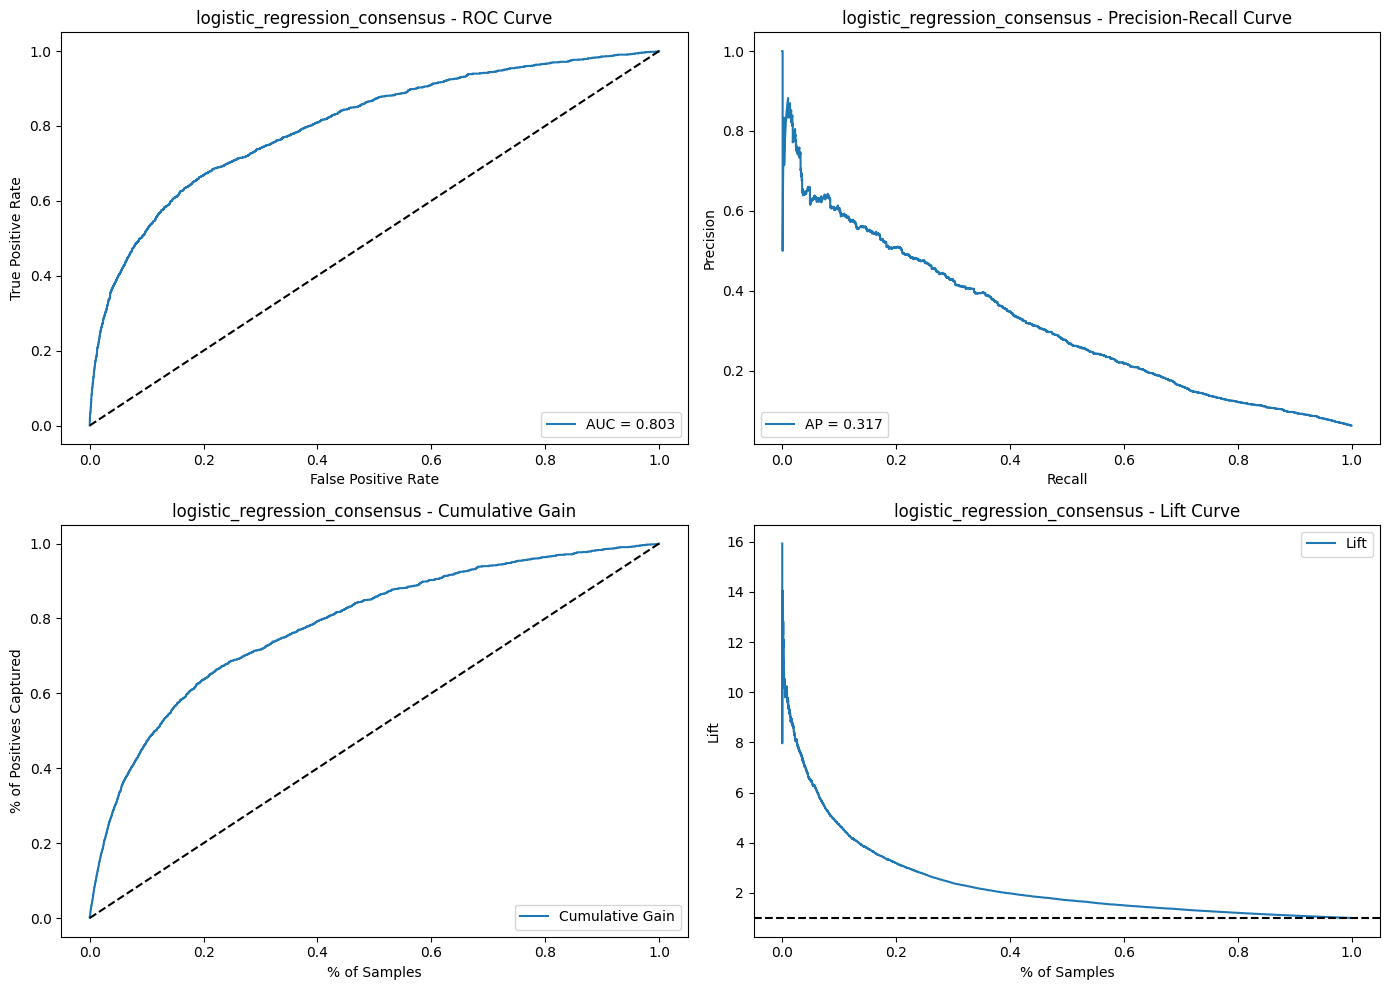

🔹 logistic_regression_consensus Metrics Summary
ROC-AUC: 0.8034
PR-AUC (Average Precision): 0.3171
KS Statistic: 0.4710

>>> Training xgboost_consensus ...
Fitting 4 folds for each of 10 candidates, totalling 40 fits


c:\Users\ivanl\OneDrive\Desktop\Python\Credit Risk Prediction\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [09:02:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification report for xgboost_consensus:
               precision    recall  f1-score   support

           0       0.98      0.77      0.86     21793
           1       0.18      0.75      0.29      1460

    accuracy                           0.77     23253
   macro avg       0.58      0.76      0.58     23253
weighted avg       0.93      0.77      0.83     23253



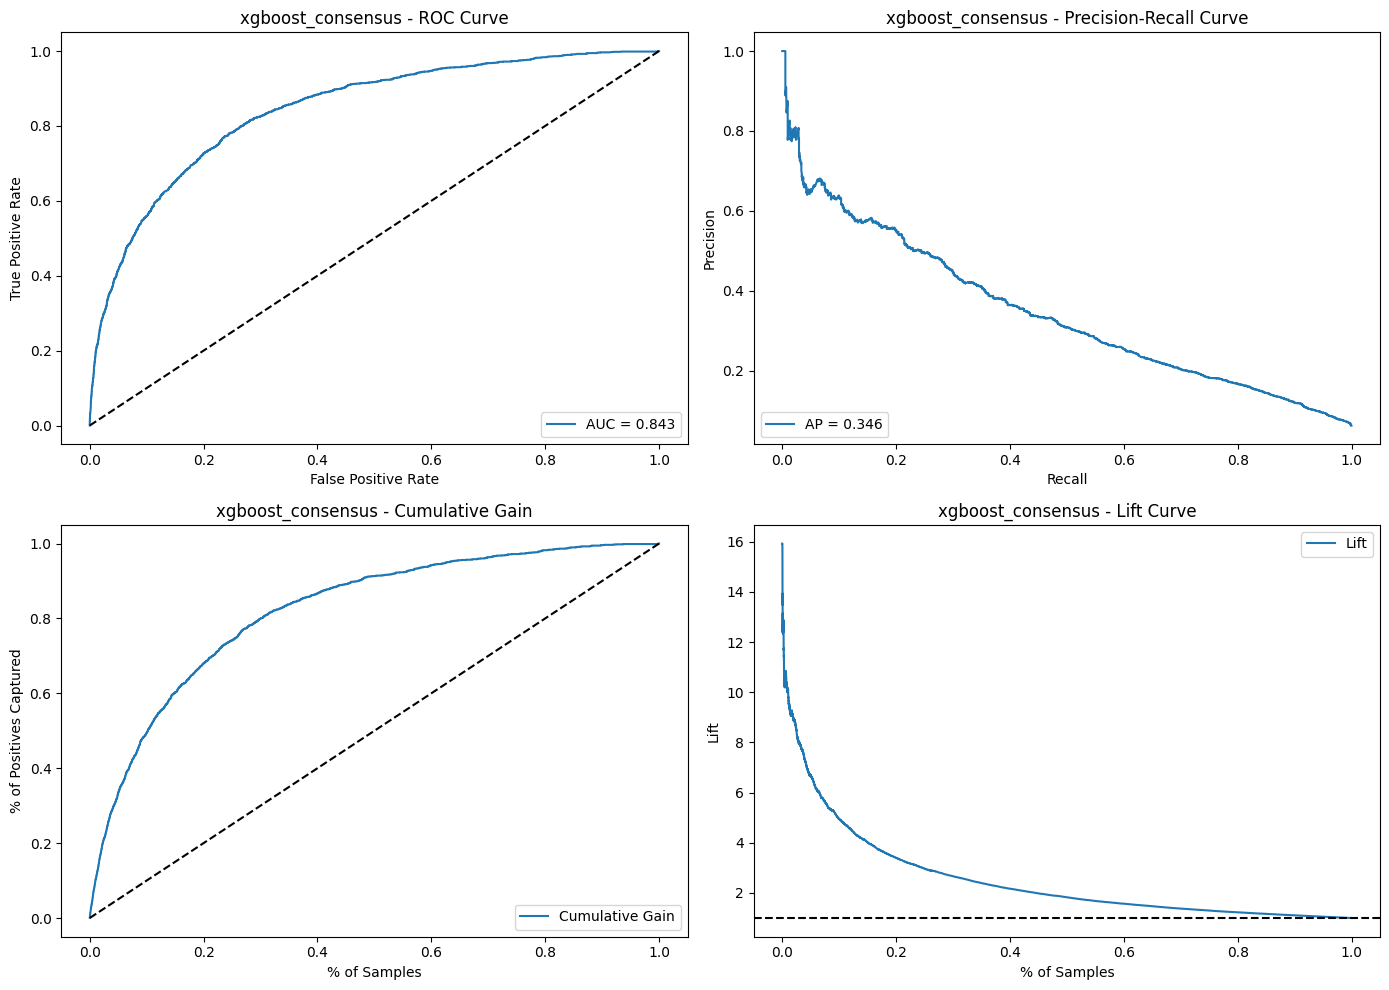

🔹 xgboost_consensus Metrics Summary
ROC-AUC: 0.8430
PR-AUC (Average Precision): 0.3461
KS Statistic: 0.5354


In [125]:
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
for name, config in models.items():
    generate_train_test_report(name,config,X_train, X_test, y_train, y_test,cv)    



In [126]:
scoreboard = pd.DataFrame(results).sort_values(by='pr_auc', ascending=False)
print("\n=== Model Comparison ===")
scoreboard


=== Model Comparison ===


,model,best_params,accuracy,precision,recall,f1,roc_auc,pr_auc
1,xgboost_full_dataset,"{'colsample_bytree': 0.7085396127095583, 'gamm...",0.804822,0.226092,0.740048,0.346366,0.857371,0.410695
7,xgboost_consensus,"{'colsample_bytree': 0.908897907718663, 'gamma...",0.770868,0.181489,0.754795,0.292618,0.843047,0.346122
0,logistic_regression_full_dataset,"{'clf__C': 6.012150117432088, 'clf__class_weig...",0.818224,0.216286,0.610374,0.319394,0.797192,0.335196
5,xgboost_mahal,"{'colsample_bytree': 0.908897907718663, 'gamma...",0.759498,0.173673,0.769608,0.283394,0.840846,0.318234
6,logistic_regression_consensus,"{'clf__C': 0.20684494295802447, 'clf__class_we...",0.844708,0.222165,0.589041,0.322641,0.803395,0.317148
4,logistic_regression_mahal,"{'clf__C': 0.5818361216819946, 'clf__class_wei...",0.834444,0.208698,0.601541,0.309885,0.789826,0.286023
3,xgboost_iforest,"{'colsample_bytree': 0.908897907718663, 'gamma...",0.734218,0.139486,0.752653,0.235354,0.814755,0.249871
2,logistic_regression_iforest,"{'clf__C': 0.20684494295802447, 'clf__class_we...",0.803824,0.155273,0.587755,0.245650,0.769992,0.211340


# Parte 2
Vemos que al final del dia el mejor modelo fue xgboost con el dataset completo, esto no me sorprende ya que xgboost bien tuneado es muy muy robusto. Como ultima prueba vamos a probar Xgboost con el dataset original, donde teniamos valores faltantes y ver si es capaz de seguir rindiendo bien

In [127]:
df_train = pd.read_csv("../data/raw/cs-training.csv")
X = df_train.drop(['SeriousDlqin2yrs','Unnamed: 0'],axis = 1)
y = df_train['SeriousDlqin2yrs']

In [128]:
X_train, X_test, y_train, y_test = get_train_test(X,y)

In [129]:
sufix = 'original_data_v2'
models = get_models(sufix,y_train)

Class ratio: 111979:8021, scale_pos_weight = 13.96


In [130]:
models.items()


dict_items([('logistic_regression_original_data_v2', {'estimator': Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LogisticRegression(max_iter=5000, random_state=42))]), 'param_distributions': {'clf__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002A0620BEFB0>, 'clf__penalty': ['l2'], 'clf__solver': ['lbfgs', 'saga'], 'clf__class_weight': [None, 'balanced']}}), ('xgboost_original_data_v2', {'estimator': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max


>>> Training xgboost_original_data_v2 ...
Fitting 4 folds for each of 10 candidates, totalling 40 fits


c:\Users\ivanl\OneDrive\Desktop\Python\Credit Risk Prediction\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [09:03:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification report for xgboost_original_data_v2:
               precision    recall  f1-score   support

           0       0.98      0.81      0.89     27995
           1       0.23      0.76      0.35      2005

    accuracy                           0.81     30000
   macro avg       0.60      0.79      0.62     30000
weighted avg       0.93      0.81      0.85     30000



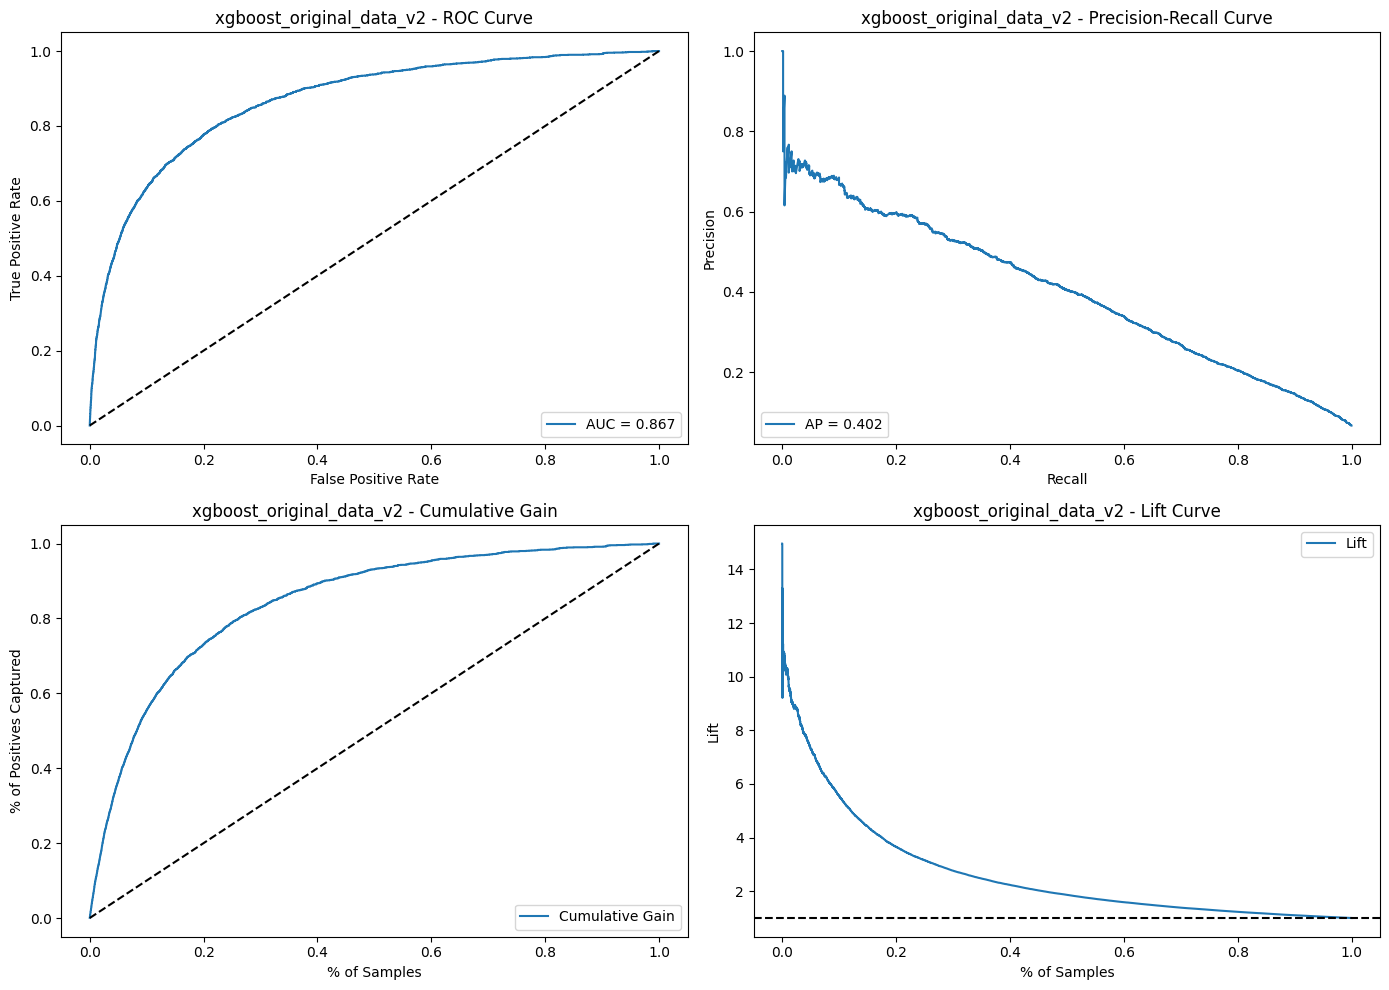

🔹 xgboost_original_data_v2 Metrics Summary
ROC-AUC: 0.8670
PR-AUC (Average Precision): 0.4019
KS Statistic: 0.5790


In [131]:
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
for name, config in models.items():
    if name =='logistic_regression_original_data_v2':
        continue
    best_model = generate_train_test_report(name,config,X_train, X_test, y_train, y_test,cv)    



In [132]:
scoreboard = pd.DataFrame(results).sort_values(by='pr_auc', ascending=False)
print("\n=== Model Comparison ===")
scoreboard


=== Model Comparison ===


,model,best_params,accuracy,precision,recall,f1,roc_auc,pr_auc
1,xgboost_full_dataset,"{'colsample_bytree': 0.7085396127095583, 'gamm...",0.804822,0.226092,0.740048,0.346366,0.857371,0.410695
8,xgboost_original_data_v2,"{'colsample_bytree': 0.7085396127095583, 'gamm...",0.809033,0.225207,0.761097,0.347569,0.867006,0.401936
7,xgboost_consensus,"{'colsample_bytree': 0.908897907718663, 'gamma...",0.770868,0.181489,0.754795,0.292618,0.843047,0.346122
0,logistic_regression_full_dataset,"{'clf__C': 6.012150117432088, 'clf__class_weig...",0.818224,0.216286,0.610374,0.319394,0.797192,0.335196
5,xgboost_mahal,"{'colsample_bytree': 0.908897907718663, 'gamma...",0.759498,0.173673,0.769608,0.283394,0.840846,0.318234
6,logistic_regression_consensus,"{'clf__C': 0.20684494295802447, 'clf__class_we...",0.844708,0.222165,0.589041,0.322641,0.803395,0.317148
4,logistic_regression_mahal,"{'clf__C': 0.5818361216819946, 'clf__class_wei...",0.834444,0.208698,0.601541,0.309885,0.789826,0.286023
3,xgboost_iforest,"{'colsample_bytree': 0.908897907718663, 'gamma...",0.734218,0.139486,0.752653,0.235354,0.814755,0.249871
2,logistic_regression_iforest,"{'clf__C': 0.20684494295802447, 'clf__class_we...",0.803824,0.155273,0.587755,0.245650,0.769992,0.211340


Al final del dia, parece que fue medio al pedo tanto laburo con outliers o sacar valores nulos ya que Xgboost maneja bien todos los casos

## Kaggle competition

Ya que esto es un dataset de Kaggle, vamos a generar las predicciones y ver como nos va!

In [133]:
X_test_final = df_test.drop(['SeriousDlqin2yrs','Unnamed: 0'],axis=1)
y_prob = best_model.predict_proba(X_test_final)[:, 1]

In [134]:
# Create the Id column (starting from 1)
ids = np.arange(1, len(y_prob) + 1)

# Create the DataFrame
submission = pd.DataFrame({
    "Id": ids,
    "Probability": y_prob
})

# Save to CSV (no index, with header)
submission.to_csv("submission.csv", index=False)

Esto nos dio un score privado de $0.86572$ lo que nos deja en el puesto 182 aproximadamente!

# Parte 3
Algo que quiero probar es, ya vimos que el modelo de Xgboost rinde bastente bien, que pasa si le sacamos las features menos informativas segun mutal_information? Ganaremos algo?

Recordemos

In [135]:
pd.Series(mi, index=X.columns).sort_values(ascending=False)

RevolvingUtilizationOfUnsecuredLines    0.035077
NumberOfTimes90DaysLate                 0.030259
NumberOfTime30-59DaysPastDueNotWorse    0.027442
NumberOfTime60-89DaysPastDueNotWorse    0.019255
NumberRealEstateLoansOrLines            0.006957
age                                     0.006235
NumberOfOpenCreditLinesAndLoans         0.004107
DebtRatio                               0.003962
MonthlyIncome                           0.003398
NumberOfDependents                      0.002316
dtype: float64

Nos vamos a quedar con solo las primeras 4 features

In [136]:
df_train = pd.read_csv("../data/raw/cs-training.csv")
X = df_train.drop(['SeriousDlqin2yrs','Unnamed: 0','age','NumberOfDependents','DebtRatio','MonthlyIncome','NumberOfOpenCreditLinesAndLoans','NumberRealEstateLoansOrLines'],axis = 1)
y = df_train['SeriousDlqin2yrs']

In [137]:
X_train, X_test, y_train, y_test = get_train_test(X,y)

In [138]:
sufix = 'feature_importance'
models = get_models(sufix,y_train)

Class ratio: 111979:8021, scale_pos_weight = 13.96



>>> Training xgboost_feature_importance ...
Fitting 4 folds for each of 10 candidates, totalling 40 fits


c:\Users\ivanl\OneDrive\Desktop\Python\Credit Risk Prediction\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [09:04:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification report for xgboost_feature_importance:
               precision    recall  f1-score   support

           0       0.98      0.76      0.86     27995
           1       0.19      0.79      0.31      2005

    accuracy                           0.77     30000
   macro avg       0.59      0.78      0.59     30000
weighted avg       0.93      0.77      0.82     30000



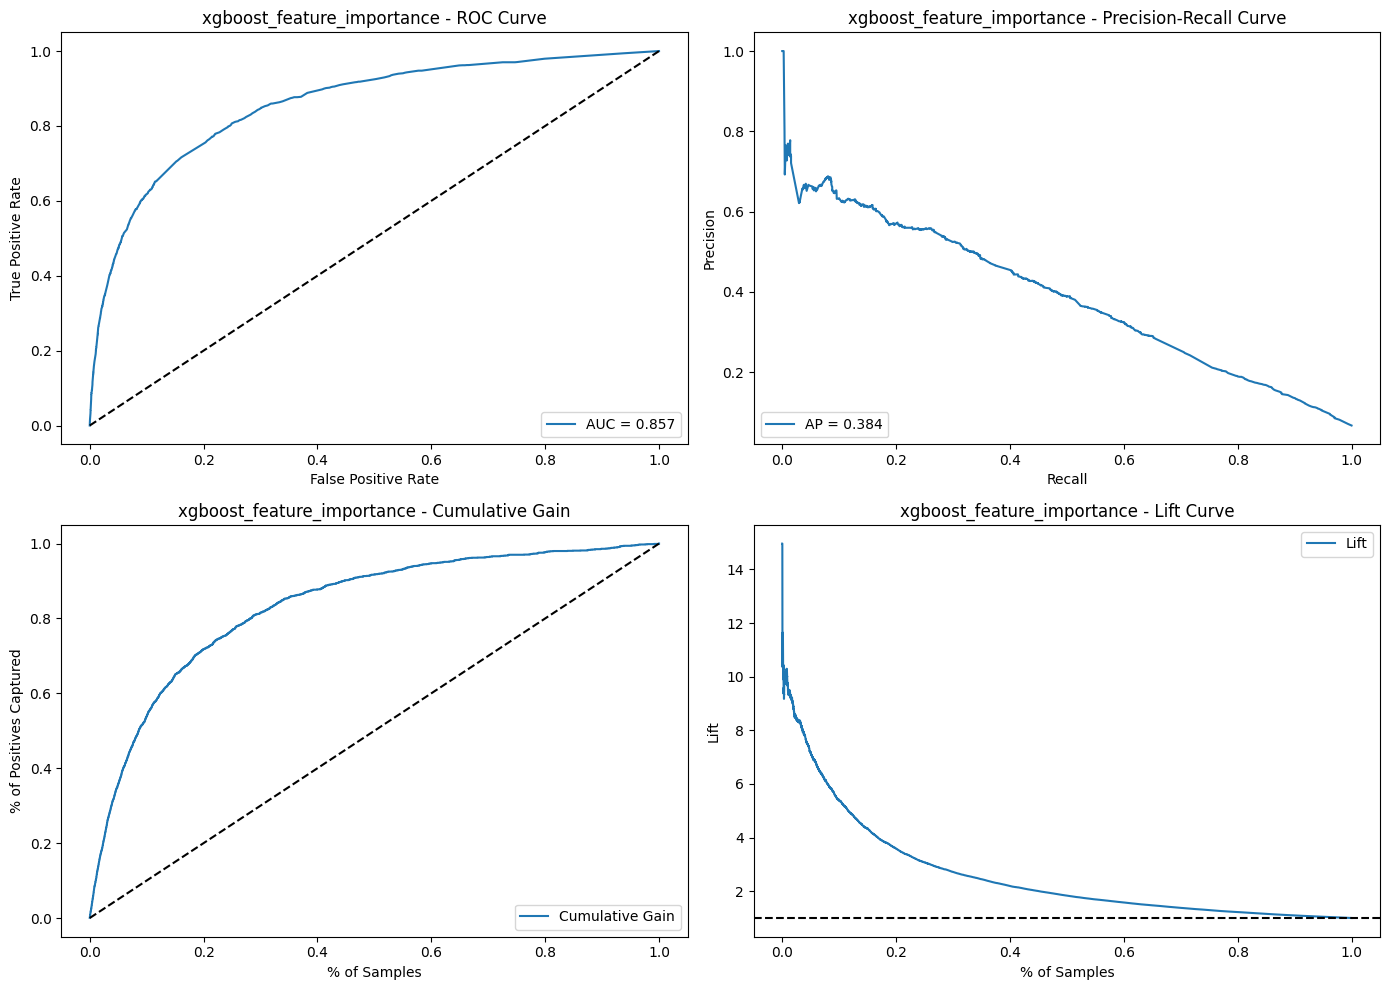

🔹 xgboost_feature_importance Metrics Summary
ROC-AUC: 0.8567
PR-AUC (Average Precision): 0.3841
KS Statistic: 0.5587


In [139]:
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
for name, config in models.items():
    if name =='logistic_regression_feature_importance':
        continue
    best_model = generate_train_test_report(name,config,X_train, X_test, y_train, y_test,cv)    



# Comparacion final

## Optimizando AUC ROC

In [140]:
scoreboard = pd.DataFrame(results).sort_values(by='pr_auc', ascending=False)
print("\n=== Model Comparison ===")
scoreboard


=== Model Comparison ===


,model,best_params,accuracy,precision,recall,f1,roc_auc,pr_auc
1,xgboost_full_dataset,"{'colsample_bytree': 0.7085396127095583, 'gamm...",0.804822,0.226092,0.740048,0.346366,0.857371,0.410695
8,xgboost_original_data_v2,"{'colsample_bytree': 0.7085396127095583, 'gamm...",0.809033,0.225207,0.761097,0.347569,0.867006,0.401936
9,xgboost_feature_importance,"{'colsample_bytree': 0.908897907718663, 'gamma...",0.766400,0.193931,0.790524,0.311456,0.856727,0.384133
7,xgboost_consensus,"{'colsample_bytree': 0.908897907718663, 'gamma...",0.770868,0.181489,0.754795,0.292618,0.843047,0.346122
0,logistic_regression_full_dataset,"{'clf__C': 6.012150117432088, 'clf__class_weig...",0.818224,0.216286,0.610374,0.319394,0.797192,0.335196
5,xgboost_mahal,"{'colsample_bytree': 0.908897907718663, 'gamma...",0.759498,0.173673,0.769608,0.283394,0.840846,0.318234
6,logistic_regression_consensus,"{'clf__C': 0.20684494295802447, 'clf__class_we...",0.844708,0.222165,0.589041,0.322641,0.803395,0.317148
4,logistic_regression_mahal,"{'clf__C': 0.5818361216819946, 'clf__class_wei...",0.834444,0.208698,0.601541,0.309885,0.789826,0.286023
3,xgboost_iforest,"{'colsample_bytree': 0.908897907718663, 'gamma...",0.734218,0.139486,0.752653,0.235354,0.814755,0.249871
2,logistic_regression_iforest,"{'clf__C': 0.20684494295802447, 'clf__class_we...",0.803824,0.155273,0.587755,0.245650,0.769992,0.211340


## Optimizando AUC PR

In [ ]:
scoreboard = pd.DataFrame(results).sort_values(by='pr_auc', ascending=False)
print("\n=== Model Comparison ===")
scoreboard


=== Model Comparison ===


,model,best_params,accuracy,precision,recall,f1,roc_auc,pr_auc
1,xgboost_full_dataset,"{'colsample_bytree': 0.8430179407605753, 'gamm...",0.808741,0.229628,0.737636,0.350229,0.858382,0.409321
8,xgboost_original_data_v2,"{'colsample_bytree': 0.8430179407605753, 'gamm...",0.811300,0.227164,0.759102,0.349684,0.867213,0.402284
9,xgboost_feature_importance,"{'colsample_bytree': 0.902144564127061, 'gamma...",0.772367,0.196985,0.782045,0.314701,0.855217,0.389327
7,xgboost_consensus,"{'colsample_bytree': 0.7085396127095583, 'gamm...",0.797747,0.195836,0.715068,0.307466,0.842966,0.351169
0,logistic_regression_full_dataset,"{'clf__C': 6.012150117432088, 'clf__class_weig...",0.818224,0.216286,0.610374,0.319394,0.797192,0.335196
5,xgboost_mahal,"{'colsample_bytree': 0.8430179407605753, 'gamm...",0.792860,0.192117,0.733894,0.304518,0.841005,0.320302
6,logistic_regression_consensus,"{'clf__C': 8.325426408004217, 'clf__class_weig...",0.844665,0.222107,0.589041,0.322581,0.803394,0.317149
4,logistic_regression_mahal,"{'clf__C': 3.043422429595377, 'clf__class_weig...",0.834444,0.208698,0.601541,0.309885,0.789826,0.286023
3,xgboost_iforest,"{'colsample_bytree': 0.908897907718663, 'gamma...",0.734218,0.139486,0.752653,0.235354,0.814755,0.249871
2,logistic_regression_iforest,"{'clf__C': 0.5818361216819946, 'clf__class_wei...",0.803824,0.155124,0.586939,0.245392,0.769991,0.211342


xgboost_feature_importance	{'colsample_bytree': 0.9579309401710595, 'gamm...	0.771967	0.193147	0.759102	0.307941	0.842494	0.365418
Estos fueron los resultados de optimizar para roc_auc